In [ ]:
from PIL import Image
import pyocr
import pyocr.builders
import io
import re
import glob
import pandas as pd
import numpy as np
from dask.delayed import delayed
import dask.dataframe as dd
from dask.diagnostics import ProgressBar, Profiler
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Identifying and Processing Definitions

## Prep 
PDF converted to images with imagemagick in the command line. i.e. 

```
parallel --eta convert -density 200 loc.ark--13960-t84j1sb5j-1480835369.pdf[{}] pages/dictionary-{}.png ::: {0..1296}
```

I manually culled non-definition pages. Specifically: 

```bash
parallel mv pages/dictionary-{}.png nondef_pages/ ::: {0..28} 113 114 269 270 275 276 345 346 367 368 443 444 791 792 {1275..1296}
```

## Pre-processing

In [ ]:
paths =glob.glob('../data/pages/dictionary-*.png')
# Pull out numbers, for easier sorting
nums = sorted([int(re.findall("\d+", path)[0]) for path in paths])

In [ ]:
tool = pyocr.get_available_tools()[0]
linebuilder = pyocr.builders.LineBoxBuilder()

In [ ]:
def parse_page_df(num, path_pattern):
    '''
    Process hOCR for a page and return the information as a DataFrame
    '''
    path = path_pattern.format(num)
    img_file = Image.open(path)
    line_boxes = tool.image_to_string(img_file, lang='eng', builder=linebuilder)
    content = [(num, i, lb.content, *lb.position[0], *lb.position[1]) for i, lb in enumerate(line_boxes)]
    return pd.DataFrame(content, columns=['pagenum', 'linenum', 'text', 'left', 'top', 'right', 'bottom'])

page = parse_page_df(565, '../data/pages/dictionary-{}.png')
page[20:24]

pagenum  linenum                                      text  left  top  \
20      565       20     awkward fellow. [A- S. ycac, cuckoo.]   913  577   
21      565       21  GAWK (gak), vi. [pr-p. GAWK’ING; pi. and   884  603   
22      565       22    p.p. GAWKED (gakt).] Behave in a gawky   912  630   
23      565       23                         or stupid manner.   913  658   

    right  bottom  
20   1392     597  
21   1479     625  
22   1480     652  
23   1137     677

In [ ]:
line_boxes

In [ ]:
line_boxes = tool.image_to_string(img_file, lang='eng', builder=linebuilder)

In [ ]:
def infer_page_details(df):
    '''
    Take a page DF of line information and add info on whether the line should
    # be ignored, what it's width is, and whether it looks like the start of 
    a definition.
    '''
    df['ignore'] = False
    df['width'] = df['right'] - df['left']
    df['height'] = df['bottom'] - df['top']

    # If there's a 1000+ pixel line in the first/last 40 lines, ignore everything before/after it
    startplace = df.query('width > 1000 & linenum < 40')['linenum'].max()
    maxline = df['linenum'].max() - 40
    endplace = df.query('width > 1000 & linenum > %d' % maxline)['linenum'].min()
    df.loc[(df['linenum'] <= startplace) | (df['linenum'] >= endplace), 'ignore'] = True

    # Ignore any other 1000+ pixel boxes
    df.loc[((df['width'] >= 1000) | (df['height'] >= 1000)), 'ignore'] = True
    
    # Ignore column headers
    df.loc[df['text'].str.match("^[A-Z\-\—]{2,}$"), "ignore"] = True

    # Ignore some watermarks that got through
    df.loc[df['text'].str.contains('ss_use|13960|ﬂhdl|22 GMT|rgfacce|Generated on |pd \\n|^Public Domain|Scotch.*owl'), 'ignore'] = True
    df.loc[(df['width'] < 40) & (df['height'] <40) & (df['text'] != ""), "ignore"] = True
    
    # Identify lines that seem to be the start of a definition: all caps, no on an ignored line,
    # and not ANT. or SYN.
    synonym = df['text'].str.startswith('SYN.')
    antonym = df['text'].str.startswith('ANT.')
    # Starts with 2+ Capital letters, eventually has a open '(' or (if the first was mis-OCR'd) a ')'
    start_def_match = df.text.str.match("^[A-Z\-\—]{2,}.*[\(\)]")
    df['def_start'] = (start_def_match & ~(synonym | antonym) & ~df['ignore'])
    
    # Identify column groups based on how much a line's left margin deviates from the previous line
    df['coldiff'] = df['left'] - df['left'].shift(1)
    df['col_group'] = (df['coldiff'].abs() > 400).cumsum()
    
    # Filter full columns, where the majority of rows are already set to ignore, or there are very few lines, 
    # or the mean width is very narrow
    def col_filter(x):
        if x['width'].mean() < 110:
            return True
        elif len(x) <= 3:
            return True
        elif x['ignore'].astype(int).mean() > 0.5:
            return True
        else:
            return False

    ignore_cols = df.groupby('col_group').apply(col_filter)
    ignore_col_groups = ignore_cols[ignore_cols].index.values
    df.loc[df['col_group'].isin(ignore_col_groups), 'ignore'] = True
    
    # Identify possible illustrations and their captions
    df['possible_pic'] = ((df['text'] == '') & 
                          (df['width'] < 600) &
                          (df['height'] < 600) &
                          ~df['col_group'].isin(ignore_col_groups))
    before_after_pic = (df['possible_pic'].shift(-1) | df['possible_pic'].shift(1)) & ~df['possible_pic']
    df["possible_caption"] = before_after_pic & df['text'].str.match("^[A-Z][\w\- ]{1,30}\.$")
    
    # Ignore illustrations. We'll pull them out later, and cross reference them to definitions on demand
    df.loc[df['possible_pic'] | df['possible_caption'], "ignore"] = True
    
    # Fix for column ordering: make sure the order is left-most, followed by top-down
    def renumber_cols(x):
        df = (x.groupby('col_group')
               .aggregate({'left': lambda x: np.floor(x.min() / 50), 'top': min})
               .sort_values(['left', 'top'])
               .copy()
              )
        df['new_col_group'] = df.index.to_series().sort_values().values
        df2 = pd.merge(x, df[['new_col_group']].reset_index(), on='col_group')
        df2.index = x.index
        return df2.drop('col_group', 1).rename(columns={'new_col_group': 'col_group'})

    df2 = renumber_cols(df)
    return df2.sort_values(['pagenum', 'col_group', 'linenum'])

details = infer_page_details(page)
details[20:22]

pagenum  linenum                                               text  left  \
56      559       56  six to forty leaves. The bales are usually Gae...   197   
57      559       57  made up of eighty hands, each of four gabillas...   198   

     top  right  bottom ignore  width  height def_start  coldiff possible_pic  \
56  1192   1445    1217   True   1248      25     False      0.0        False   
57  1219   1446    1243   True   1248      24     False      1.0        False   

   possible_caption  col_group  
56            False          0  
57            False          0

In [ ]:
details

pagenum  linenum                                               text  \
0        559        0                                                  G   
1        559        1                                           GAFFSMAN   
2        559        2                                                      
3        559        3                     3 (1e), 1|. (pl. G’S (1am Sev-   
4        559        4                         enth letter in the English   
5        559        5                        alphabet. It is a consonant   
6        559        6                            and has two sounds: (1)   
7        559        7                        hard, heard when the letter   
8        559        8                    occurs before a, o, u, l, or r,   
9        559        9                            and in words of English   
10       559       10                      origin before 9 and 1', as in   
11       559       11                           yet, give, and when ﬂnal   
12       559       12   (except after n, as in sing); (2) soft, commonly   
13       559       13     heard before e, t, and y, as in gem, gin, gym-   
14       559       14        nasl. Before m and n this letter usually is   
15       559       15          silent, as in gnat, phlegm. In respeliing   
16       559       16      iur pronunciation in this dictionary the hard   
17       559       17        sound is always indicated by g and the soft   
18       559       18                                        sound by j.   
19       559       19                                                      
20       559       20           Window with its upper part shaped like a   
21       559       21                                             gable.   
22       559       22     GABRIEL (ga’brl-el), n. Heb. Itlyth. Prince oi   
23       559       23               ﬁre and thunder, and angel of death.   
24       559       24     GAD (gall), n. Wedge of steel; pointed instru-   
25       559       25        ment; graver; prod; stick; rod. [A. S. god,   
26       559       26                                             goad.]   
27       559       27   GAD (gad), vi. [pt-.11. GAD’DING; pi. and 11.1).   
28       559       28         GAD’DEDJ Rove about idly or for diversion.   
29       559       29      GADABOUT (gad’a-bowt), l. a. Addicted to gad—   
..       ...      ...                                                ...   
73       559       73                                                      
74       559       74                                                      
75       559       75                                                      
76       559       76  3 exterior Wall of 3. Sharp—pointed iron hook,...   
77       559       77  E g a building bla- iarge ﬁsh after they have ...   
78       559       78  “a ‘- tween the top of line and spent by the s...   
79       559       79  -'= I— .‘ the side-walls Bnnm m- spar extendin...   
80       559       80  HI; and the slopes sail not set on stays. [Fr....   
81       559       81  E :I of the roof. GAFF (gaf), u. [pr.p. GAFF’I...   
82       559       82  h [0- Fr- gﬂble; A. GAFFED (gaft).] I. vt. Str...   
83       559       83  U  5- HWﬂ, fork] with a gaff. 11. vi. Use a gaﬂ'.   
84       559       84  ” ll GABLED (ga’bld), 0. Having gables or a ga...   
85       559       85  IH _:- GABLE-END (ga’bl-end), n. Arch. End wal...   
86       559       86  a of a. building on the side where there is a ...   
87       559       87  d. GABLE-ROOFED7(ga’bi-r6ft), a. Having a GAFF...   
88       559       88  9 '00! converged to an apex, as a ridge-roof G...   
89       559       89  ﬂ '3": terminating in a gable. 2. Iron hook or...   
90       559       90  I E' ‘ CABLE-WINDOW (ga’bl-win-do), n. 1. Win-...   
91       559       91  3 J: i 50“ in the gable-end 0f 3 building. 2. ...   
92       559       92                                               a h.   
93       559       93  I: E  ‘ - rite, lat. task. tar

In [ ]:
path_pattern = '../data/pages/dictionary-{}.png'

In [ ]:
delayed_dfs = []
for i in sorted(nums):
    page_hOCR = delayed(parse_page_df)(i, path_pattern)
    judged_df = delayed(infer_page_details)(page_hOCR)
    delayed_dfs.append(judged_df)
    
full_book_ddf = dd.from_delayed(delayed_dfs)

# Group together definition lines
full_book_ddf['word_group'] = full_book_ddf['def_start'].cumsum()

# Ensure no lines go over 400 chars
full_book_ddf['text'] = full_book_ddf['text'].apply(lambda x:x[:400])

with ProgressBar(), Profiler() as prof:
    full_book_ddf.to_hdf("dictionary.h5", "/full", complib='blosc', min_itemsize={'text':400})

/opt/conda/lib/python3.5/site-packages/dask/dataframe/core.py:1865: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


[#########################               ] | 62% Completed | 14min  2.8s

If something changes in infer_page_details, you can re-do analysis without re-OCRing the pages

```allp = allp.groupby('pagenum', as_index=False).apply(infer_page_details)```

In [ ]:
prof.visualize()

Figure(id='50c52f28-0ab3-4283-aa7a-e8df41565aa7', ...)

## Load the saved full-info DataFrame

In [ ]:
allp = dd.read_hdf('./dictionary.h5', 'full').compute()
allp.query('ignore != True')[::30000]

pagenum  linenum                                            text  left  \
40       29       40                           usually consisting of   912   
77      310       77         tester, bcar Witness; testis, witness.]   932   
38      586       38                               muzzle, and great   260   
25      885       25      Surplus; remainder; proﬁt. (L. plus, more]   210   
44     1165       44  bottom of the stalk of a plant. (A. S. telgor,   192   

     top  right  bottom ignore  width  height def_start  coldiff  col_group  \
40  1260   1163    1279  False    251      19     False    678.0          9   
77   232   1370     253  False    438      21     False      0.0          3   
38   407    495     427  False    235      20     False      1.0          2   
25   595    774     617  False    564      22     False      1.0          2   
44  1172    758    1193  False    566      21     False     30.0          1   

   possible_pic possible_caption  word_group  
40        False            False           0  
77        False            False        8854  
38        False            False       17757  
25        False            False       27185  
44        False            False       36325

In [ ]:
def renumber_cols(x):
    df = (x.groupby('col_group')
           .aggregate({'left': lambda x: np.floor(x.min() / 50), 'top': min})
           .sort_values(['left', 'top'])
           .copy()
          )
    df['new_col_group'] = df.index.to_series().sort_values().values
    df2 = pd.merge(x, df[['new_col_group']].reset_index(), on='col_group')
    df2.index = x.index
    return df2.drop('col_group', 1).rename(columns={'new_col_group': 'col_group'})

In [ ]:
allp = allp.groupby('pagenum').apply(renumber_cols).sort_values(['pagenum', 'col_group', 'linenum'])


In [ ]:
allp.query('(pagenum >= 565) & (pagenum <= 570)').groupby('word_group').filter(lambda x: (x.pagenum.max()-x.pagenum.min()) > 1)

pagenum  linenum                                               text  left  \
24      565       24         GAWKINESS (gak’i-nes), n. Quality of being   884   
1       565        1                                               GEAR  1143   
86      565       86                                                     1215   
82      565       82                                                     1532   
79      565       79                                                     1578   
80      565       80                                                     1575   
96      566       96                         Generated on 2016-12434 03    46   
97      566       97                               Public Domain f hiip    78   
98      566       98                                                       37   
66      566       66                                    {139601134415th    46   
67      566       67                                                 pd    78   
68      566       68                                            ss_use#    80   
69      566       69                                                 .2    46   
70      566       70                                                 I—    50   
71      566       71                                                 "l    52   
72      566       72                                                  U    52   
73      566       73                                                  2    46   
74      566       74                                              in...    48   
75      566       75                                                 h.    48   
76      566       76                                                  N    48   
77      566       77                                                  D    48   
78      566       78                                                  N    48   
79      566       79                                                33'    48   
80      566       80                                                  U    52   
81      566       81                                                '=.    52   
82      566       82                                                  2    46   
83      566       83                                                 'D    46   
84      566       84                                                 I:    52   
85      566       85                                                 II    52   
86      566       86                                               -'=.    46   
..      ...      ...                                                ...   ...   
47      566       47  process of converting or being converted Whole...   251   
48      566       48  into galaﬁﬂ 01' jelW'like SUbSW-nce- whole. 3....   252   
49      566       49  GELATINIZE (jel-at’i-niz), M. and 1112. Same a...   224   
50      566       50  . GELATINATE. ‘ Loose; vague. II. n. 1. Whole ...   241   
51      566       51  GELATINOUS (jel-at’i-nus). a. Consisting Of 2....   223   
52      566       52  01' resembling gemtin- ment. 3. Military ofﬁce...   252   
53      566       53  GELATION(je-la’shun>,n. Solidiﬂcationbycold. a...   223   
54      566       54  GELE‘: (geld), 1:1. [pr.p. GELD’ING; p.12 and ...   223   
55      566       55  GELD’ED.] 1. Emascuiate. 2. Deprive of Fr.—L. ...   253   
56      566       56  anything essential. [Ice. geldaJ GENERALISSIMO...   251   
57      566       57  GELDING (gelding), 11- Castrated animal. comma...   223   
58      566       58                          especially a horse. {It.]   251   
59      566       59  UELID (jel'id), a. Icy cold; cold. [L. geh’dus...   224   
60      566       60  cold.] being general. 2. DIain part: greatest ...   251   
61      566       61  GEM (lem), n. 1. Bud. 2. Precious stone 3. Vag...   223   
62      566       62  espcciaily when cut. 3. Anything extremely gen...   251   
63      566       63  valuable or attractive. 4. Small, round cake. ...   251   
64      566       64  [L. gemmaJ 1.

In [ ]:
allp['word_group'] = allp['def_start'].cumsum()

In [ ]:
allp[allp.text.str.contains('gaw', case=False)]

pagenum  linenum                                               text  \
39       119       39              SYN. Gawky; boorish; uncouth; clumsy;   
134      138      134     BAUBLE (ba’bl), n. 1. Piece of tinsel; gewgaw;   
48       193       48  f 1 . UDAPESTOW ‘1" 9950’ "' Cﬂp‘tamrﬁmgaw' BU...   
39       565       39   GATHER (gath’ér), v. [pup GATH’ERING; pd. gawky.   
40       565       40  and pm. GATHERED (gaih’él'd).] I. vt. 1. GAWKY...   
42       565       42  ference. II. vi. 1. Assemble; muster. 2. GAWP ...   
43       565       43  Increase. 3. Suppurate. [A. S. gardertan— GAWP...   
19       565       19            GAWK (gak). n. 1. Cuckoo. 2. Simpleton;   
21       565       21           GAWK (gak), vi. [pr-p. GAWK’ING; pi. and   
22       565       22             p.p. GAWKED (gakt).] Behave in a gawky   
24       565       24         GAWKINESS (gak’i-nes), n. Quality of being   
64       570       64           GEWGAW (gﬁ’ga), I. n. Toy; bauble: showy   
44       633       44      a openedup through an ice- gawk). ICENOGRAPE-   
56       732       56  MAGAW (mi-blag, n. Large beautiful 2. One Who ...   
94      1219       94       preceding the main body. [0. Fr. mmnt-gawleJ   

     left   top  right  bottom ignore  width  height def_start  coldiff  \
39    270  1022    777    1042  False    507      20     False     30.0   
134   911  1716   1500    1737  False    589      21      True    -28.0   
48     46  1091   1473    1124   True   1427      33     False   -340.0   
39    208   710    999     733  False    791      23      True    -29.0   
40    237   736   1480     758   True   1243      22     False     29.0   
42    238   790   1479     813   True   1241      23     False      0.0   
43    237   817   1481     840   True   1244      23     False     -1.0   
19    883   550   1478     571  False    595      21      True    -30.0   
21    884   603   1479     625  False    595      22      True    -29.0   
22    912   630   1480     652  False    568      22     False     28.0   
24    884   683   1480     705  False    596      22      True    -29.0   
64    242  1159    831    1179  False    589      20      True    -28.0   
44     48   978   1209    1015   True   1161      37     False      0.0   
56    236  1567   1310    1602   True   1074      35     False    -30.0   
94    865   509   1432     530  False    567      21     False     27.0   

    possible_pic possible_caption  word_group  col_group  
39         False            False        2736          2  
134        False            False        3381          7  
48         False            False        5306          0  
39         False            False       17070          5  
40         False            False       17070          5  
42         False            False       17070          5  
43         False            False       17070          5  
19         False            False       17085          9  
21         False            False       17086          9  
22         False            False       17086          9  
24         False            False       17087          9  
64         False            False       17183          2  
44         False            False       19319          0  
56         False            False       22392          1  
94         False            False       38066          2

In [ ]:
allp.query('(pagenum>=565) & (word_group >= 17070)').iloc[50:]

pagenum  linenum                                               text  \
10       565       10                                       being gauzy.   
11       565       11         GAUZY (gaz’i). a. Like gauze: thin and di-   
12       565       12                                          aphanous.   
13       565       13                GAVE (gay), 4;. Past tense of GIVE.   
14       565       14    GAVEL (gav’l), n. 1. Mallet used by a presiding   
15       565       15        oiﬁcer. 2. Mason’s mallet. [0. Fr. gavelleJ   
16       565       16       GAVOTTE (ga-vot’), n. 1. Yivaclous, digniﬁed   
17       565       17            French dance. 2. Music in the rhythm of   
18       565       18                                   this dance. [FL]   
19       565       19            GAWK (gak). n. 1. Cuckoo. 2. Simpleton;   
20       565       20              awkward fellow. [A- S. ycac, cuckoo.]   
21       565       21           GAWK (gak), vi. [pr-p. GAWK’ING; pi. and   
22       565       22             p.p. GAWKED (gakt).] Behave in a gawky   
23       565       23                                  or stupid manner.   
24       565       24         GAWKINESS (gak’i-nes), n. Quality of being   
1        565        1                                               GEAR   
86       565       86                                                      
82       565       82                                                      
79       565       79                                                      
80       565       80                                                      
96       566       96                         Generated on 2016-12434 03   
97       566       97                               Public Domain f hiip   
98       566       98                                                      
66       566       66                                    {139601134415th   
67       566       67                                                 pd   
68       566       68                                            ss_use#   
69       566       69                                                 .2   
70       566       70                                                 I—   
71       566       71                                                 "l   
72       566       72                                                  U   
..       ...      ...                                                ...   
107     1274      107     ZYHOSES (zi-mo’sis), n. Pathol. Process of fer   
108     1274      108           mentation by which a malarious or simila   
109     1274      109          poison is introduced into the system. [3:   
110     1274      110            zymdsis, fermentation—zymé, leaven, for   
111     1274      111                                           ment.] '   
112     1274      112      ZYMOTIC (zi-mot’ik), a. Pertaining to, or pro   
113     1274      113            duced by, fermentation. Zymotic disease   
114     1274      114       any contagious or epidemic disease due to ﬁx   
115     1274      115            resence of some mnrhiﬁc element produce   
116     1274      116          by fermentation. [G12 zylmitikos—zyma‘sis   
117     1274      117                                      fermentationJ   
118     1274      118          ZYMURGY (zi’mﬁr-ji), n. Departmentof tech   
119     1274      119     nological chemistry which treats of the. scien   
120     1274      120       tiﬁc principles of Wine-making. brewing, etc   
121     1274      121               [Gin zymé, ferment, and ergon, workJ   
122     1274      122         ZYTHle (zi'thum), n. Kind of fermented bev   
123     1274      123             erage or beer made from malt and wheat   
124     1274      124              used by the ancient Egyptians. [IniGr   
125     1274      125                            zythos, a kind of been}   
126     1274      126               eromu (ziks-om'a), n. Genus of India   
127     1274      127      dragonflies, with large he

## Combine definitions

In [ ]:
definitions = allp.query('ignore != True')\
                  .groupby(['word_group', 'col_group', 'pagenum'], as_index=False).agg({
                                'text': lambda x: ' \n '.join(x.tolist()),
                                'left':'min',
                                'top':'min',
                                'right':'max',
                                'bottom':'max',
                                'linenum': lambda x: str((min(x), max(x))) # as str for hdfstore support
                               })\
                 .query('(right-left)<1000')\
                 .sort_values(['word_group', 'pagenum', 'col_group'])

definitions.sample(4)

word_group  col_group  pagenum  left  \
23540       22864          4      748   932   
5940         5765          5      212   921   
38591       37461          4     1204   927   
30531       29654          2      955   179   

                                                    text  right     linenum  \
23540  LATED.) 1. ct. Admit to membership by \n enter...   1497  (104, 108)   
5940   CANNONEER, CANNONIER (kan-un-ér’), n. \n Gunne...   1509    (93, 94)   
38591  UNBLUSHING (un-blush’ing). a. Not blushing: \n...   1516  (126, 127)   
30531  EEFECTION (re-fek’shun), n. Retreshment; \n me...    770    (22, 24)   

        top  bottom  
23540   508     635  
5940    684     731  
38591  1558    1607  
30531   377     450

In [ ]:
definitions['word'] = definitions['text'].str.findall("^[A-Z\-]{2,}[ \(\.]").apply(lambda x: x[0][:-1] if len(x) > 0 else "")
definitions.loc[(definitions['word'] == "SYN") | (definitions['word'] == "ANT"), "word"] = ""

# Drop when there was a word identified in the second row of a definition
definitions['part'] = definitions.groupby('word_group')['word'].transform(lambda x: range(1,1+len(x))).astype(int)
non_empty_second_rows = (definitions['part'] > 1) & (definitions['word'] != "")
definitions.loc[(non_empty_second_rows | non_empty_second_rows.shift(-1)), "word"] = ""

with pd.HDFStore('./dictionary.h5') as store:
    store.append('/definitions', definitions)

## Identify likely illustrations

In [ ]:
# Extract illustrations
illustrations_raw = allp[allp['possible_pic'] | allp['possible_caption']]
illustrations_raw['pic'] = (~(illustrations_raw['linenum']-1 == illustrations_raw['linenum'].shift(1))).cumsum()
illustrations = illustrations_raw.groupby(['pagenum', 'col_group', 'pic'], as_index=False)\
                                 .agg({'left':min, 'top': min, 'right':max, 'bottom':max})\
                                 .query('((right-left) >15) & ((bottom-top) >15) & ((right-left) <1000) & ((bottom-top) < 1000)')
illustrations.sample(3)

with pd.HDFStore('./dictionary.h5', mode='a') as store:
    store.append('/illustrations', illustrations)

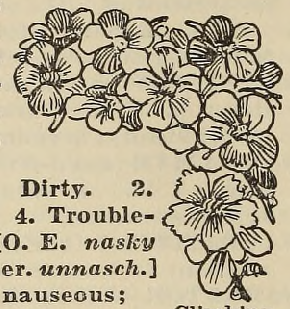

In [ ]:
def img_from_illustration(row):
    return Image.open(path_pattern.format(row['pagenum'])).crop((row['left']-3, row['top']-3, row['right']+3, row['bottom']+3))
    
img_from_illustration(illustrations.sample().iloc[0])

In [ ]:
testrow = definitions.iloc[[365]]
testrow

word_group  col_group  pagenum  left  \
366         355          0       41   193   

                                                  text  right   linenum   top  \
366  ADDITIONAL (ad-dish’un—al), a. Being in the \n...    788  (55, 56)  1477   

     bottom        word  part  
366    1522  ADDITIONAL     1

In [ ]:
worddef = testrow[['pagenum', 'left', 'top', 'right', 'bottom']].values[0]
pad = 100
corners = []
for h in worddef[1::2]:
    for v in worddef[2::2]:
        hit = ((illustrations['pagenum'] == worddef[0]) & 
              (illustrations['left']-pad < h) & (illustrations['right']+pad > h) & 
              (illustrations['top']-pad < v) & (illustrations['bottom']+pad > v))
        corners.append(hit)

pic_matches = pd.concat(corners, axis=1).any(axis=1)
illustrations[pic_matches]

Empty DataFrame
Columns: [pagenum, col_group, pic, left, bottom, right, top]
Index: []

In [ ]:
def img_from_row(row):
    ''' Input: series'''
    hpad = 6
    wpad = 25
    path = path_pattern.format(row['pagenum'])
    img_file = Image.open(path)
    return img_file.crop((row['left']-wpad, row['top']-hpad, row['right']+wpad, row['bottom']+hpad))

def img_from_match(matches):
    ''' Potentially combine multiple rows'''
    if len(matches) == 1:
        img = img_from_row(matches.iloc[0])
        return img
    else:
        hpad = 6
        wpad = 25

        hsize = (matches['bottom'] - matches['top']).sum() + 2*hpad
        wsize = (matches['right'] - matches['left']).max() + 2*wpad

        new_im = Image.new('RGB', (wsize, hsize))
        y_offset = 0

        for i, match in matches.iterrows():
            img = img_from_row(match)
            new_im.paste(img, (0, y_offset))
            y_offset += img.height
        return new_im

In [ ]:
illustrations.sample(1).iloc[0].to_frame().T

pagenum  col_group   pic  left  bottom  right  top
1067     1072          1  1057  1243     846   1466  413

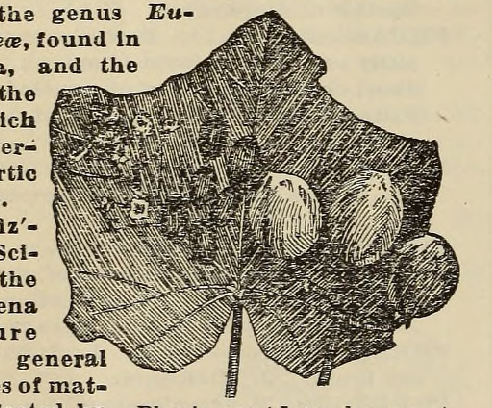

In [ ]:
img_from_match(illustrations.sample(1))

## Save all illustrations to disk

In [ ]:
img_from_match(illustrations.sample(1))

i = len(illustrations)
for i, match in illustrations.iterrows():
    img = img_from_illustration(match)
    img.save("../data/illustration_images/{}.png".format(i))
    i -= 1
    if i % 10 == 0:
        print(i)

In [ ]:
# Rewriting updated stores
with pd.HDFStore('./dictionary.h5', mode='w') as store:
    store.append('/definitions', definitions)
    store.append('/full', allp)
    store.append('/illustrations', illustrations)

# Uncommon Words

Before writing 

To overcome OCR issues, I'll cross reference the list of definitions that I found with HathiTrust's OCR for two copies of this book. This will still leaves ample definitions. To identify "uncommon", I cross-referenced the list with the 700k most common words in the HathiTrust.

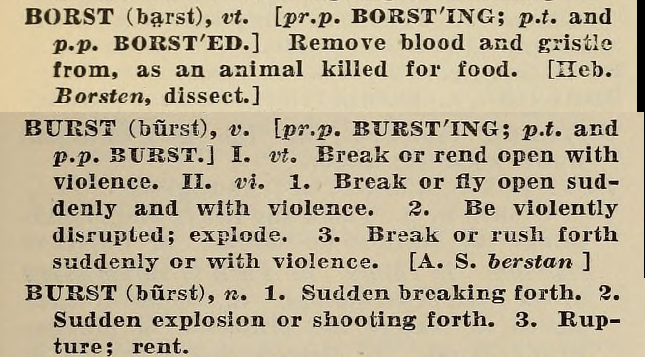

In [ ]:
match = query_definitions("BURST")
img_from_match(match)

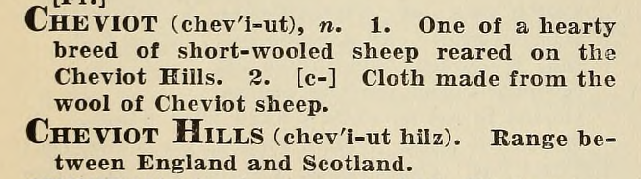

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(b)
img_from_match(match)

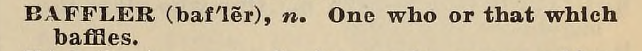

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

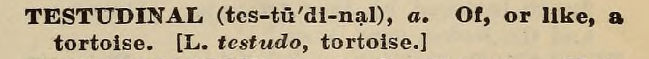

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

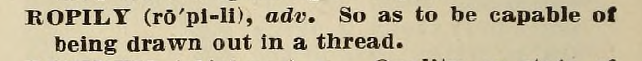

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

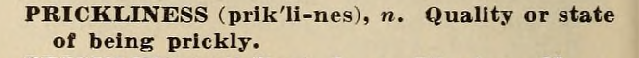

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

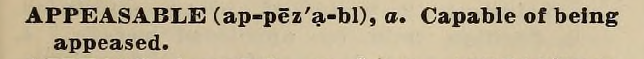

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)